<h1>Прогнозирование заказов такси</h1>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Стоит построить модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Целевой признак - num_orders - количество заказов.

**План работы**: первым делом загрузим данные и выполним ресемплирование по одному часу, затем - проанализируем данные, создадим новые признаки, обучим различные модели с разными гиперпараметрами, в конце проверим модель на тестовой выборке и сделаем выводы.

<h3>Оглавление</h3>

1. [Шаг 1: Знакомство с данными, ресемплирование](#samples)
2. [Шаг 2: Исследовательский анализ](#res)
3. [Шаг 3: Добавление новых признаков](#preproc)
4. [Шаг 4: Обучение моделей](#models)
5. [Шаг 5: Выводы и выбор лучшией модели](#test_sanity)

<h3>Шаг 1: Знакомство с данными, ресемплирование</h3>
<a id='samples'></a>

Начнем с импортирования необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
import warnings
from copy import deepcopy
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings(action='ignore')

Загрузим данные.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=['datetime'])

Ознакомимся с данными.

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Мы располагаем значениями, которые снимали каждые 10 минут. Время и дата, с которых началась запись значений, - это полночь 1 марта, а время и дата, на которых данные действия завершились, - это 31 августа 12 часов ночи. То есть - значения с 1 марта по 31 августа - за 6 месяцев. Год везде один - 2018.

Проведем ресемплирование по одному часу.

In [5]:
data = data.resample('1H').sum()

Посмотрим, сколько сейчас значений.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


26.5 тысяч значений превратились в 4.5 тысяч.

**Вывод по Шагу 1**: на данном шаге мы загрузили данные - причем в виде, удобном для анализа и прогнозирования временных рядов, также провели процедуру ресемплирования и узнали количество значений, предоставленных для работы.

<h3>Шаг 2: Исследовательский анализ</h3>
<a id='res'></a>

Познакомимся с полученными данными ближе.

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Итак, в среднем за эти шесть месяцев в час было 84 заказа, при этом минимальное значение равно нулю, максимальное 462. При этом разница между первым и третьим квартилем не такая большая, что говорит о том, что такие высокие значения как, например, 462 встречаются нечасто.

Теперь графики. 

**Графики**

Разложим временной ряд на тренд, сезонность и остаток. 

In [8]:
decomposed = seasonal_decompose(data)

Разберемся с трендом.

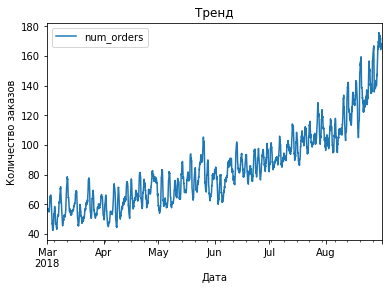

In [9]:
decomposed.trend.plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Тренд')
plt.show()

Очевидно - есть тренд к увеличению количества заказов. 

Теперь остатки.

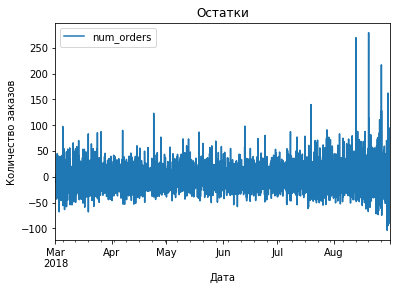

In [10]:
decomposed.resid.plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Остатки')
plt.show()

Остатки в целом находятся  одном диапазоне - от -10 до 10, это радует. Разве что, к концу ряда происходят неожиданные вещи. Но общие изменения не наблюдаются.

А сейчас самое интересное - сезонная составляющая.

Если строить график для всего ряда, что получается синее полотно, так что будем рассматривать меньшие отрезки.

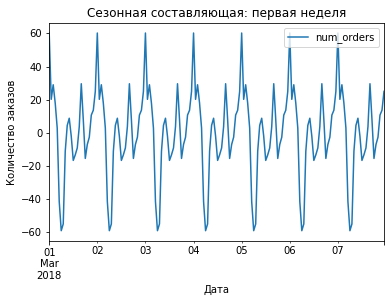

In [11]:
decomposed.seasonal[:'2018-03-07'].plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Сезонная составляющая: первая неделя')
plt.show()

Очень хорошо получилось. Между количеством заказов и временем суток существует четкая зависимость.

Посмотрим на две недели.

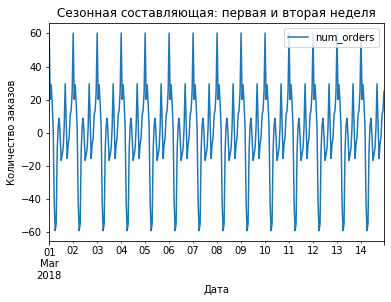

In [12]:
decomposed.seasonal[:'2018-03-14'].plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Сезонная составляющая: первая и вторая неделя')
plt.show()

Результат тот же. Присутствует ярко выраженная сезонность, есть тренд. Только вот сезонность отразилась не вся, вполне вероятно, что что-то попало в остатки: а именно, зависимость от того, выходной день или нет, пятница ли - как минимум (какой день недели?). Рассмотрим, от чего еще может зависеть количество заказов.

*День недели*

Построим случайную неделю.

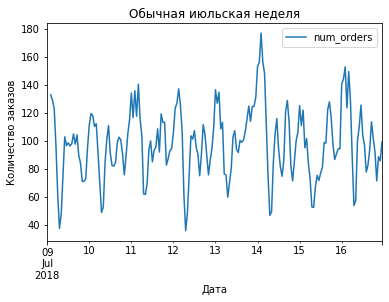

In [13]:
data['2018-07-09':'2018-07-16'].rolling(3).mean().plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Обычная июльская неделя')
plt.show()

Что мы видим - в пятницу и воскресенье вечерний пик выше, также суббота не особо вписывается в тот сезонный паттерн, что мы обнаружили ранее.

Из этой же серии: стоит учитывать государственные праздники, так как это выходные дни.

Возможно, влияет время года, но у нас данные лишь за полгода - причем это все весна и лето, так что мы можем опираться лишь на зависимость ото дня недели и времени суток.

**Вывод по Шагу 2**: итак, мы исследовали наши данные. Обнаружили тренд, а также сезонность: количество заказов меняется в зависимости от времени суток и дня недели.

<h3>Шаг 3: Добавление новых признаков</h3>
<a id='preproc'></a>

Настало время новых признаков. 

Первым делом добавим: число, день недели, час, месяц.

Здесь сразу следует сказать - расценивать день недели как числовой признак не совсем корректно, поскольку это закодированные категории, которые НЕЛЬЗЯ интерпретировать именно как числа. В отличии от столбцов час и число. Мы это здесь сразу учтем. Воспользуемся OHE для варианта датасета, который пойдет в регрессию. Для деревянных моделей оставим вариант 'как было'.

День недели добавим позже.

In [14]:
data['day'] = data.index.day
data['hour'] = data.index.hour
data['month'] = data.index.month

Добавим отстающие значения: три штуки.

In [15]:
data['lag_1'] = data['num_orders'].shift(1)
data['lag_2'] = data['num_orders'].shift(2)
data['lag_3'] = data['num_orders'].shift(3)
data['lag_4'] = data['num_orders'].shift(24)

Добавим скользящее среднее. Интервал окна - 24 * 7 - так модель сможет учесть общий тренд. 

In [16]:
data['trendy'] = data['num_orders'].shift().rolling(24*7).mean()

Теперь копируем датасет и проводим обещанные манипуляции с признаком день недели.

In [17]:
data_tree = deepcopy(data)
data['dayofweek'] = data.index.dayofweek.astype('object')
data = pd.get_dummies(data)
data_tree['dayofweek'] = data.index.dayofweek

**Вывод по Шагу 3**: итак, на данном Шаге мы добавили новых признаков - день месяца, час суток, день недели, а также - три отстающих значения и скользящее среднее за неделю.

<h3>Шаг 4: Обучение моделей</h3>
<a id='models'></a>

Приступаем к самому интересному - обучению моделей. Начнем с деления на выборки. Нам нужна тестовая выборка размером 10 процентов от данных. Также еще 20 процентов (от оставшегося количества) будем использовать как валидационную выборку. Остальное - обучающая.

Метрика качества у нас rmse.

In [18]:
train, test, ttrain, ttest = train_test_split(data, data_tree, shuffle=False, test_size=0.1)

In [19]:
train, valid, ttrain, tvalid = train_test_split(train, ttrain, shuffle=False, test_size=0.2)

Удалим пропуски из обучающей выборки.

In [20]:
train = train.dropna().reset_index(drop=True)
ttrain = ttrain.dropna().reset_index(drop=True)

Отделим целевой признак.

In [21]:
target_train = train['num_orders']
feat_train = train.drop(columns=['num_orders'])
target_test = test['num_orders']
feat_test = test.drop(columns=['num_orders'])
target_valid = valid['num_orders']
feat_valid = valid.drop(columns=['num_orders'])
feat_ttrain = ttrain.drop(columns=['num_orders'])
feat_ttest = ttest.drop(columns=['num_orders'])
feat_tvalid = tvalid.drop(columns=['num_orders'])

Начнем с линейной регрессии. У нас гребневая вместо классической.

**Ridge Regression**

Напишем функцию для лучшей проверки качества.

In [22]:
def metr(model):
    predicted_tr = model.predict(feat_train)
    predicted_v = model.predict(feat_valid)
    rmse_tr = round(mean_squared_error(predicted_tr, target_train) ** 0.5,0)
    rmse_v = round(mean_squared_error(predicted_v, target_valid) ** 0.5,0)
    print('RMSE на тренировочной выборке: {}'.format(rmse_tr))
    print('RMSE на валидационной выборке: {}'.format(rmse_v))
    print('R2 на тренировочной выборке: {:.2}'.format(model.score(feat_train, target_train)))
    print('R2 на валидационной выборке: {:.2}'.format(model.score(feat_valid, target_valid)))

Теперь сама регрессия.

Поэкспериментируем здесь с гиперпараметром альфа.

In [23]:
alpha = [0.1, 0.5, 0.75, 1, 2, 5, 10, 15]

In [24]:
best_a = 0
bs = 100
for a in alpha:
    model1 = Ridge(random_state=12345, alpha=a)
    model1.fit(feat_train, target_train)
    predicted = model1.predict(feat_valid)
    rmse = mean_squared_error(predicted, target_valid) ** 0.5
    if rmse < bs:
        bs = rmse
        best_a = a

Оценим получившееся лучшее значение и обучим именно такую модель.

Соберем перед этим обучающую и валидационную выборки в одну.

In [25]:
'Лучшее значение альфа: {}'.format(best_a)

'Лучшее значение альфа: 15'

In [26]:
model1 = Ridge(random_state=12345, alpha=15)
model1.fit(feat_train, target_train)
metr(model1)

RMSE на тренировочной выборке: 24.0
RMSE на валидационной выборке: 34.0
R2 на тренировочной выборке: 0.5
R2 на валидационной выборке: 0.36


RMSE не такое большое, особенно на обучающей выборке.

Дальше посмотрим, как справится случайный лес. 

**Случайный лес**

Поэкспериментируем с гиперпараметрами.

In [27]:
bs = 100
bmd = 0
bne = 0
for md in range(2, 15):
    for ne in range(5, 51, 5):
        model2 = RandomForestRegressor(random_state=12345, max_depth=md, n_estimators=ne)
        model2.fit(feat_ttrain, target_train)
        predicted = model2.predict(feat_tvalid)
        rmse = mean_squared_error(predicted, target_valid) ** 0.5
        if rmse < bs:
            bs = rmse
            bmd = md
            bne = ne

Посмотрим на лучшие параметры.

In [28]:
'Лучшая максимальная глубина: {}. Лучшее количество деревьев: {}'.format(bmd, bne)

'Лучшая максимальная глубина: 14. Лучшее количество деревьев: 45'

Обучим такую модель.

In [29]:
model2 = RandomForestRegressor(random_state=12345, max_depth=14, n_estimators=45)
model2.fit(feat_ttrain, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=45,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [30]:
def tmetr(model):
    predicted_tr = model.predict(feat_ttrain)
    predicted_v = model.predict(feat_tvalid)
    rmse_tr = round(mean_squared_error(predicted_tr, target_train) ** 0.5,0)
    rmse_v = round(mean_squared_error(predicted_v, target_valid) ** 0.5,0)
    print('RMSE на тренировочной выборке: {}'.format(rmse_tr))
    print('RMSE на валидационной выборке: {}'.format(rmse_v))
    print('R2 на тренировочной выборке: {:.2}'.format(model.score(feat_ttrain, target_train)))
    print('R2 на валидационной выборке: {:.2}'.format(model.score(feat_tvalid, target_valid)))

In [31]:
tmetr(model2)

RMSE на тренировочной выборке: 10.0
RMSE на валидационной выборке: 33.0
R2 на тренировочной выборке: 0.92
R2 на валидационной выборке: 0.41


Качество лучше, чем у регрессии. Безусловно - случайный лес наиболее вероятный кандидат для выбора на данный момент.

Попробуем еще градиентный бустинг.

**Градиентный бустинг**

Будем менять максимальную глубину дерева, а также количество деревьев в ансамбле.

In [32]:
bs = 100
bmd = 0
bne = 0
for md in range(2, 15):
    for ne in range(5, 101, 5):
        model3 = LGBMRegressor(random_state=12345, max_depth=md, n_estimators=ne)
        model3.fit(feat_ttrain, target_train)
        predicted = model3.predict(feat_tvalid)
        rmse = mean_squared_error(predicted, target_valid) ** 0.5
        if rmse < bs:
            bs = rmse
            bmd = md
            bne = ne

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

Посмотрим на лучшие параметры.

In [33]:
'Лучшая максимальная глубина: {}. Лучшее количество деревьев: {}'.format(bmd, bne)

'Лучшая максимальная глубина: 8. Лучшее количество деревьев: 70'

Обучим такую модель.

In [34]:
model3 = LGBMRegressor(random_state=12345, max_depth=8, n_estimators=70)
model3.fit(feat_ttrain, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=70, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
tmetr(model3)

RMSE на тренировочной выборке: 14.0
RMSE на валидационной выборке: 31.0
R2 на тренировочной выборке: 0.82
R2 на валидационной выборке: 0.46


Градиентный бустинг показал результат еще лучше.

**Выводу по Шагу 4**: итак, на данном Шаге мы обучили 3 различных модели, для каждой из которых меняли некоторые гиперпараметры. В итоге получили гребневую регрессию, случайный лес и обученный алгоритм градиентного бустинга. Также у каждой модели проверили качество.

<h3>Шаг 5: Выводы и выбор лучшие модели</h3>
<a id='test_sanity'></a>

На прошлом этапе мы обучали модели. Настало время выбрать лидера.

Очевидно, это градиентный бустинг. Вспомним, как он показал себя.

In [36]:
tmetr(model3)

RMSE на тренировочной выборке: 14.0
RMSE на валидационной выборке: 31.0
R2 на тренировочной выборке: 0.82
R2 на валидационной выборке: 0.46


Теперь проверим качество данной модели на тестовой выборке.

Перед этим обучимся на обучающей и валидационной выборке вместе.

In [37]:
model3 = LGBMRegressor(random_state=12345, max_depth=8, n_estimators=70)
model3.fit(pd.concat([feat_ttrain, feat_tvalid]), pd.concat([target_train, target_valid]))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=70, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [38]:
predicted_best = model3.predict(feat_ttest)
rmse = round(mean_squared_error(predicted_best, target_test) ** 0.5,0)
print('RMSE на тестовой выборке: {}'.format(rmse))
print('R2 на тестовой выборке: {:.2}'.format(model3.score(feat_ttest, target_test)))

RMSE на тестовой выборке: 40.0
R2 на тестовой выборке: 0.54


RMSE меньше 48, что соответствует условию. Да и в целом - значение метрики не такое высокое.

**Вывод по Шагу 5**: итак, на данном шаге мы выбрали лучшую модель, а также проверили ее качество на тестовой выборке.